In [1]:
import numpy as np
import random
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import deepcopy

In [2]:
class SnakeGame:
    def __init__(self, board_size=40):
        self.board_size = board_size
        self.reset()

    def reset(self):
        self.board = np.zeros((self.board_size, self.board_size), dtype=int)
        self.snake = [(self.board_size // 2, self.board_size // 2)]
        self.board[self.snake[0]] = -1
        self.direction = (0, 1)  #Start moving to the right
        self.spawn_food()
        self.done = False
        return self.board

    def spawn_food(self):
        empty_spaces = np.argwhere(self.board == 0)
        if len(empty_spaces) == 0:
            self.done = True
            return
        food_position = random.choice(empty_spaces)
        self.board[tuple(food_position)] = 1

    def step(self, action):
        if self.done:
            raise ValueError("Game is over. Please reset the game.")

        # 0: up, 1: right, 2: down, 3: left
        directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.direction = directions[action]

        new_head = (self.snake[0][0] + self.direction[0], self.snake[0][1] + self.direction[1])

        # Check if the new head is out of bounds or hits the snake body
        if (new_head[0] < 0 or new_head[0] >= self.board_size or
            new_head[1] < 0 or new_head[1] >= self.board_size or
            self.board[new_head] == -1):
            self.done = True
            return deepcopy(self.board), -1, deepcopy(self.done), {}  # Game over (minus reward)

        # Check if the new head is on the food
        if self.board[new_head] == 1:
            self.snake.insert(0, new_head)  # Add new head to the snake, first idx in list of snake body points
            self.board[new_head] = -1
            self.spawn_food() 
            return deepcopy(self.board), 1, deepcopy(self.done), {}  # Reward for eating food

        # Move the snake
        self.snake.insert(0, new_head)
        self.board[new_head] = -1
        tail = self.snake.pop()
        self.board[tail] = 0

        return deepcopy(self.board), 0, deepcopy(self.done), {}  # Normal step with no reward

    def render(self):
        return deepcopy(self.board)

[True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False]


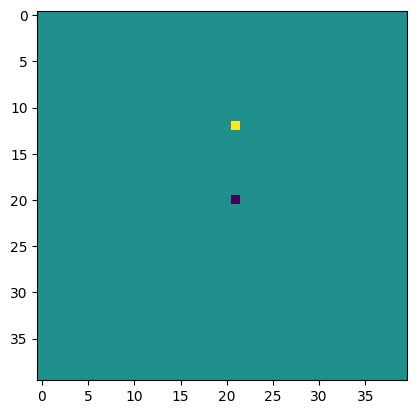

In [3]:
#game setup test

game = SnakeGame()
game.reset()

list_imgs = []
# #testing
actions = [1, 2, 3, 0]  
for i in range(100):
    board, reward, done, _ = game.step(actions[i % 4])
    list_imgs.append(board)
    if done:
        print("Game Over")
        break

truth_arr = [np.all(x == list_imgs[0]) for x in list_imgs]
print(truth_arr)

fig, ax = plt.subplots()
im = ax.imshow(list_imgs[0])

def update(frame):
    im.set_array(list_imgs[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(list_imgs), interval=1000, blit=True)

# saves the animation in our desktop 
#ani.save('snaketest.gif', writer = 'Pillow', fps = 30) 

In [ ]:
#setup policy 

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=4, kernel_size=3, stride=1)       
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 3, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1)
        
        # one dropout layer
        self.dropout = nn.Dropout(0.8)
        # one dense layer
        self.final_dense = nn.Linear(11200, output_dim) 

        self.batchnorm1 = nn.BatchNorm2d(4)
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.batchnorm3 = nn.BatchNorm2d(16)

        for m in (self.conv1, self.conv2, self.conv3, self.final_dense):   #converts from default weight normalization to glorot
            nn.init.constant_(m.bias,0)
            nn.init.xavier_normal_(m.weight, np.sqrt(2))

    # forward-pass function
    def forward(self, x):
        x = relu(self.conv1(x))     #after each convolution, pool and normalize
        x = self.pool(x)            #used to reduce dimensionality
        x = self.batchnorm1(x)
        x = self.dropout(x)
        
        x = relu(self.conv2(x))
        x = self.pool(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        
        x = relu(self.conv3(x))
        x = self.pool(x)
        x = self.batchnorm3(x)
        
#         x = relu(self.conv4(x))
#         x = self.pool(x)
#         x = self.batchnorm4(x)
        
#         x = relu(self.conv5(x))
#         x = self.pool(x)
#         x = self.batchnorm5(x)
        
        x = x.reshape(len(x),-1)
        x = self.dropout(x)
        x = softmax(self.final_dense(x), dim = 1)
        
        return x

# Example usage:
input_dim = (40,40)
output_dim = 4  # Four possible actions: up, down, left, right

policy_net = PolicyNetwork(input_dim, output_dim)


In [ ]:
#setup critic
class CriticNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=4, kernel_size=3, stride=1)       
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels = 4, out_channels = 8, kernel_size = 3, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1)
        
        # one dropout layer
        self.dropout = nn.Dropout(0.8)
        # one dense layer
        self.final_dense = nn.Linear(11200, output_dim) 

        self.batchnorm1 = nn.BatchNorm2d(4)
        self.batchnorm2 = nn.BatchNorm2d(8)
        self.batchnorm3 = nn.BatchNorm2d(16)

        for m in (self.conv1, self.conv2, self.conv3, self.final_dense):   #converts from default weight normalization to glorot(xavier)
            nn.init.constant_(m.bias,0)
            nn.init.xavier_normal_(m.weight, np.sqrt(2))

    # forward-pass function
    def forward(self, x):
        x = relu(self.conv1(x))     #after each convolution, pool and normalize
        x = self.pool(x)            #used to reduce dimensionality
        x = self.batchnorm1(x)
        x = self.dropout(x)
        
        x = relu(self.conv2(x))
        x = self.pool(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        
        x = relu(self.conv3(x))
        x = self.pool(x)
        x = self.batchnorm3(x)
        
#         x = relu(self.conv4(x))
#         x = self.pool(x)
#         x = self.batchnorm4(x)
        
#         x = relu(self.conv5(x))
#         x = self.pool(x)
#         x = self.batchnorm5(x)
        
        x = x.reshape(len(x),-1)
        x = self.dropout(x)
        x = softmax(self.final_dense(x), dim = 1)
        
        return x

# Example usage:
input_dim = (40,40)
output_dim = 1  # one ouput, the predicted value of the state

value_net = CriticNetwork(input_dim, output_dim)


In [ ]:
loss_module = ClipPPOLoss(
    actor_network=policy_net,
    critic_network=value_net,
    clip_epsilon=clip_epsilon,
    entropy_bonus=True,
    entropy_coef=0.005,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

In [ ]:
def get_train_data(env, policy_net, critic_net, gamma):
    #should return
    
    #current state
    #action chosen at that state
    #log probabilites of actions at this current state, from which the action was chosen
    #dones: a flag indicating whether the end of an episode
    #reward: reward for taking the action chosen
    #return: sum of all future rewards
    #gamma: fixed discount factor for future rewards

    state_list = []
    state = torch.tensor(env.reset(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    done = False

    while not done:
        #get action probabilities from the policy network
        logits = policy_net(state)
        action_probs = torch.softmax(logits, dim=1).squeeze(0).detach().numpy()

        #choose action
        action = np.random.choice(len(action_probs), p=action_probs)
        
        #step env
        next_state, reward, done, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        #save trajectory information
        state_value = critic_net(state).item()
        log_prob = torch.log(torch.tensor(action_probs[action]))

        state_list.append([state, action, log_prob, done, reward, state_value])
        state = next_state

    # Calculate returns and advantages
    get_returns(state_list, gamma)
    get_advantages(state_list)
    return state_list

def get_returns(state_list, gamma):
    #for each state and associated data in list, sum all subsequent rewards til fin
    
    for i in range(len(state_list)):
        gamma_disc = 1
        #state_list[i][-2] initialized to 0
        for y in range(len(state_list)-i):
            gamma_disc *= gamma
            state_list[i][-2] += gamma_disc * state_list[y+i+1][4]
def get_advantages(state_list):
    for state in state_list:
        advantage = state[-1] - state[5]  # Return - Value
        state.append(advantage)

In [ ]:
policy_optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
value_optimizer = optim.Adam(value_net.parameters(), lr=1e-4)


In [ ]:
num_epochs = 1000
gamma = 0.99
clip_epsilon = 0.2

env = SnakeGame()

for epoch in range(num_epochs):
    trajectories = get_train_data(env, policy_net, value_net, gamma)

    states = torch.cat([s[0] for s in trajectories])
    actions = torch.tensor([s[1] for s in trajectories], dtype=torch.int64)
    log_probs_old = torch.cat([s[2] for s in trajectories])
    returns = torch.tensor([s[3] for s in trajectories], dtype=torch.float32)
    advantages = torch.tensor([s[4] for s in trajectories], dtype=torch.float32)

    #update policy (actor)
    logits = policy_net(states)
    log_probs_new = torch.log_softmax(logits, dim=1).gather(1, actions.unsqueeze(1)).squeeze(1)
    ratios = torch.exp(log_probs_new - log_probs_old)
    surr1 = ratios * advantages
    surr2 = torch.clamp(ratios, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
    actor_loss = -torch.min(surr1, surr2).mean()

    #update value function (critic)
    values = value_net(states).squeeze(1)
    critic_loss = nn.functional.smooth_l1_loss(values, returns)

    loss = actor_loss + critic_loss

    #non-manual, use this
    # # Compute loss using ClipPPOLoss
    # loss = loss_module(
    #     states=states,
    #     actions=actions,
    #     logprobs=log_probs_old,
    #     returns=returns,
    #     advantages=advantages,
    # )


    policy_optimizer.zero_grad()
    value_optimizer.zero_grad()
    loss.backward()
    policy_optimizer.step()
    value_optimizer.step()

    # Logging
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

In [ ]:
#after completing all training

In [ ]:
game = SnakeGame()
game.reset()

list_imgs = []
# #testing
done = false
total_reward = 0
while done == false:
    board, reward, done, _ = game.step(value_net(game.render())
    list_imgs.append(board)
    reward += reward

print("Game terminated w reward :" + reward)

fig, ax = plt.subplots()
im = ax.imshow(list_imgs[0])

def update(frame):
    im.set_array(list_imgs[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(list_imgs), interval=1000, blit=True)

# saves the animation in our desktop 
ani.save('snaketest.gif', writer = 'Pillow', fps = 30) 